## Notes

In questo notebook vengono implementati i modelli di classificazione del BBCH (creati da Marco Cristoforetti nel notebook `modello_enophit_per_varieta.ipynb`) aggiungendo pulizia del codice, sotring e plotting delle metriche e dei modelli rispetto al codice originale. 

- Ogni sample di training è un array di 366 valori di temperatura, inizializzato a -999
- Viene incluso il valore di bbch di quel giorno, infatti l'array di temperature è rimepito fino a quel giorno con le temperature dell'anno, il rimanenete rimane a -999.
- Questo viene fatto perché l'imput del modello è fisso, non può essere variabile

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm, tqdm_notebook
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as utils_data
import torch.nn.functional as F

# from bokeh.io import show, output_notebook
# from bokeh.plotting import figure, output_file, show
# from bokeh.palettes import Spectral4
# from bokeh.layouts import column

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

DAYS_IN_YEAR = 366
BATCH_SIZE = 10

metrics_linear_columns = ['Epoch', 'Loss_te', 'Acc', 'Loss_tr']
metrics_conv_columns = ['Epoch', 'Loss_te', 'Loss_tr']

Loading BokehJS ...

In [2]:
def plot_metrics_data(metrics_data):
    # create a new plot with a datetime axis type
    p1 = figure(plot_width=800, plot_height=250, x_axis_label="Epoch")
    for name, color in zip(["Loss_tr", "Loss_te"], Spectral4):
        p1.line(metrics_data['Epoch'], metrics_data[name], line_width=2, color=color, alpha=0.8, legend=name)
    if 'Acc' in metrics_data.columns:
        p2 = figure(plot_width=800, plot_height=250, x_axis_label="Epoch")
        p2.line(metrics_data['Epoch'], metrics_data['Acc'], line_width=2, color="red", alpha=0.8, legend="Acc")
        show(column(p1, p2))
    else:
     show(p1)

In [3]:
!ls 

modello_enophit_new.ipynb              ph_model_1_model_20181130_135830.pkl
modello_enophit_per_varieta.ipynb      ph_model_1_weights_20181130_135830.pkl
ph_model_0_metrics_20181130_135830.pkl ph_model_b_metrics_20181130_135730.pkl
ph_model_0_model_20181130_135830.pkl   ph_model_b_model_20181130_135730.pkl
ph_model_0_weights_20181130_135830.pkl ph_model_b_weights_20181130_135730.pkl
ph_model_1_metrics_20181130_135830.pkl


#### Load data files

`*_tr` > training data  
`*_te` > test data

We do not shuffle data and test only on (2017) recent data because we need to predict the next season. So shuffling the data would be cheating.

In [15]:
temperature_tr = pd.read_pickle(f'{_input_data_folder}temps_2011_2016.pkl')
rilevazioni_tr = pd.read_pickle(f'{_input_data_folder}rilevazioni_2011_2016.pkl')

temperature_te = pd.read_pickle(f'{_input_data_folder}2017_daily_temps_for_each_point.pkl')
rilevazioni_te = pd.read_pickle(f'{_input_data_folder}rilevazioni_2017.pkl')

varieta_tr = pd.read_pickle(f'{_input_data_folder}varieta_2011_2016.pkl')
varieta_te = pd.read_pickle(f'{_input_data_folder}varieta_2017.pkl')

# Each plant variety has its own code
nome_varieta = pd.read_pickle(f'{_input_data_folder}varieta_id_e_nome.pkl')

In [16]:
nome_varieta.loc[298]

varieta    CHARDONNAY B.
Name: 298.0, dtype: object

#### Get Chardonnay Data

In [9]:
# Get all the coordinates (particella centroid) that have a chardonnay collection
# The Colums index of the dataframe is the centroid of the particella.
chardonnay = varieta_tr[varieta_tr == 298].fillna(0).sum()
chardonnay_ix = chardonnay[chardonnay > 0].index.values  # list of centroids / particelle with chardonnay collections

# same for 2017
chardonnay_te = varieta_te[varieta_te == 298].fillna(0).sum()
chardonnay_te_ix = chardonnay_te[chardonnay_te > 0].index.values

# Get rilevazioni and temperatures from chardonnay collections periods
rilevazioni_tr = rilevazioni_tr[chardonnay_ix]
temperature_tr = temperature_tr[chardonnay_ix]

rilevazioni_te = rilevazioni_te[chardonnay_te_ix]
temperature_te = temperature_te[chardonnay_te_ix]

In [10]:
# Exclude all the collections preceeding 2015
rilevazioni_tr = rilevazioni_tr[rilevazioni_tr.index >= pd.Timestamp(2015, 1, 1)]

In [11]:
def create_dataset(temperature, rilevazioni):
    """
    TODO: Document this procedure
    """
    # Number of maximum samples
    num_rilevazioni = rilevazioni.astype(bool).sum().sum()
    
    # Each `temps_data` row contains the temperatures relative to that `bbch_data` 
    # cell from the first day of that year up to six days prior the collection of that bbch
    temps = np.ones((num_rilevazioni, DAYS_IN_YEAR)) * (-999.0)
    bbch = np.zeros(num_rilevazioni)
    
    j = 0
    # Iterate over the particelle
    for i in range(rilevazioni.shape[1]):
        rilev = rilevazioni.iloc[:, i][rilevazioni.iloc[:, i] != 0]
        date = rilev.index
        particella = rilevazioni.columns[i]
        # iterate over the date of collection of chardonnay in this particella
        for k, data in enumerate(date):
            # get the temperatures the beginning of this year up to six days prior this date
            temps_data = temperature[particella][
                (temperature[particella].index >= pd.Timestamp(data.year, 1, 1)) & 
                (temperature[particella].index < data - pd.to_timedelta(6, unit='d'))
            ].values
            # temps[j, :len(temps_data)] = (temps_data) / (temps_data.mean())
            temps[j, :len(temps_data)] = temps_data
            # temps[j] = np.exp(temps[j])
            bbch[j] = rilev.values[k]
            j += 1

    # create binary dataset for classifier of "low" bbch and "high" bbch        
    bbch_b = np.zeros(bbch.shape)
    bbch_b[:] = bbch[:]
    bbch_b[bbch_b <= 30] = 0
    bbch_b[bbch_b > 30] = 1
    return temps, bbch, bbch_b

#### Create training dataset

In [12]:
temps_data, bbch_data, bbch_data_b = create_dataset(temperature=temperature_tr, rilevazioni=rilevazioni_tr)

In [13]:
temps_data[0][300]

-999.0

#### Create test dataset

In [14]:
temps_data_te, bbch_data_te, bbch_data_te_b = create_dataset(temperature=temperature_te, rilevazioni=rilevazioni_te)

#### Create Torch Datasets

In [15]:
rilevazioni_tr.shape

(702, 1237)

In [16]:
configs_tr = torch.from_numpy(temps_data).type(torch.FloatTensor).to(device)
configs_te = Variable(torch.from_numpy(temps_data_te).type(torch.FloatTensor)).to(device)

bbch_b_tr= torch.from_numpy(bbch_data_b).type(torch.FloatTensor).to(device)
bbch_b_te = Variable(torch.from_numpy(bbch_data_te_b).type(torch.FloatTensor)).to(device)

training_samples = utils_data.TensorDataset(configs_tr, bbch_b_tr)
data_loader_tr = utils_data.DataLoader(training_samples, batch_size=BATCH_SIZE, shuffle=True)

#### Classifier

In [17]:
class pheno_model_classifier(nn.Module):
    def __init__(self, input_size=DAYS_IN_YEAR):
        # super(pheno_model_classifier, self).__init__()
        nn.Module.__init__(self)
        
        self.input_size = input_size
        self.start_n = (input_size + 1) // 2
        self.lin1 = nn.Linear(self.input_size, self.start_n)
        self.lin2 = nn.Linear(self.start_n, int(self.start_n / 2))
        self.lin3 = nn.Linear(int(self.start_n / 2), 1)

    def forward(self, x):
        x = self.lin1(x)
        x = torch.sigmoid(x)
        x = F.dropout(x, p=0.4)
        x = self.lin2(x)
        x = torch.sigmoid(x)
        x = F.dropout(x, p=0.4)
        x = self.lin3(x)
        x = torch.sigmoid(x)

        return x

**Train the classifier and output metrics**

In [18]:
ph_model_b = pheno_model_classifier().to(device)

In [22]:
# Init a dataframe to store the training metrics
metrics_linear_model = pd.DataFrame(columns=metrics_linear_columns)

loss_f = nn.MSELoss()

optimizer = torch.optim.Adam(ph_model_b.parameters(), lr=0.0001)
num_epochs = 5
with tqdm(total=100) as pbar:
    for epoch in range(num_epochs):
        pbar.n = 0
        pbar.refresh()
        loss_mean = 0.
        pbar.set_description('Epoch %d' % epoch )

        for i, (confs, bbch) in enumerate(data_loader_tr):
            confs_tmp = Variable(confs)
            bbch_tmp = Variable(bbch.type(torch.FloatTensor)).to(device)

            optimizer.zero_grad() # zero the gradient buffer
            outputs = ph_model_b(confs_tmp)
            loss = loss_f(outputs.resize_as(bbch_tmp), bbch_tmp)

            loss.backward()
            optimizer.step()
            loss_mean = (loss_mean * i + loss.item()) / (i + 1)
            if ((i+1) % (len(training_samples) // 10 // BATCH_SIZE)) == 0:
                pbar.set_postfix(Loss_tr = loss_mean)
                pbar.update(10)

        outputs = ph_model_b(configs_te)
        loss_te = loss_f(outputs.resize_as(bbch_b_te), bbch_b_te)
        acc = accuracy_score(np.round((outputs.resize_as(bbch_b_te).data).cpu().numpy()).astype(int), bbch_b_te.data.cpu().numpy())
#         pbar.set_postfix(Loss_te = loss_te.item(), Acc=acc, Loss_tr = loss_mean)
        metrics_linear_model = metrics_linear_model.append(pd.Series([epoch, loss_te.item(), acc, loss_mean], index=metrics_linear_columns), ignore_index=True)
        pbar.update()
print("Done.")

Epoch 0:   0%|          | 0/100 [00:00<?, ?it/s]/home/fioravanzo/anaconda3/envs/pei/lib/python3.7/site-packages/torch/tensor.py:268: UserWarning: non-inplace resize_as is deprecated
  warnings.warn("non-inplace resize_as is deprecated")
Epoch 199:  90%|█████████ | 90/100 [01:01<00:59,  5.91s/it, Loss_tr=0.0454]

Done.


In [23]:
plot_metrics_data(metrics_linear_model)

In [48]:
# Save model weights and metrics
model_name = 'ph_model_b'
now = datetime.now().strftime('%Y%m%d_%H%M%d')
torch.save(ph_model_b.state_dict(), f"./{model_name}_weights_{now}.pkl")
torch.save(ph_model_b, f"./{model_name}_model_{now}.pkl")
metrics_linear_model.to_pickle(f"./{model_name}_metrics_{now}.pkl")

Load training and testing date into tensors to train convolutional network

In [28]:
bbch_tr_0 = bbch_data[np.argwhere(bbch_data_b == 0).reshape(-1,)] / 25.
bbch_tr_0 = torch.from_numpy(bbch_tr_0).type(torch.FloatTensor).to(device)
bbch_te_0 = bbch_data_te[np.argwhere(bbch_data_te_b == 0).reshape(-1,)] / 25.
bbch_te_0 = Variable(torch.from_numpy(bbch_te_0).type(torch.FloatTensor)).to(device)

bbch_tr_1 = (bbch_data[np.argwhere(bbch_data_b == 1).reshape(-1,)] - 53) / (99. - 53.)
bbch_tr_1 = torch.from_numpy(bbch_tr_1).type(torch.FloatTensor).to(device)
bbch_te_1 = (bbch_data_te[np.argwhere(bbch_data_te_b == 1).reshape(-1,)] - 53) / (99. - 53.)
bbch_te_1 = Variable(torch.from_numpy(bbch_te_1).type(torch.FloatTensor)).to(device)

configs_tr_0 = torch.from_numpy(temps_data[np.argwhere(bbch_data_b == 0).reshape(-1,)].reshape(-1, 1, DAYS_IN_YEAR)).type(torch.FloatTensor).to(device)
configs_te_0 = Variable(torch.from_numpy(temps_data_te[np.argwhere(bbch_data_te_b == 0).reshape(-1,)].reshape(-1, 1, DAYS_IN_YEAR)).type(torch.FloatTensor)).to(device)

configs_tr_1 = torch.from_numpy(temps_data[np.argwhere(bbch_data_b == 1).reshape(-1,)].reshape(-1, 1, DAYS_IN_YEAR)).type(torch.FloatTensor).to(device)
configs_te_1 = Variable(torch.from_numpy(temps_data_te[np.argwhere(bbch_data_te_b == 1).reshape(-1,)].reshape(-1, 1, DAYS_IN_YEAR)).type(torch.FloatTensor)).to(device)

In [29]:
training_samples_0 = utils_data.TensorDataset(configs_tr_0, bbch_tr_0)
data_loader_tr_0 = utils_data.DataLoader(training_samples_0, batch_size=BATCH_SIZE, shuffle=True)

training_samples_1 = utils_data.TensorDataset(configs_tr_1, bbch_tr_1)
data_loader_tr_1 = utils_data.DataLoader(training_samples_1, batch_size=BATCH_SIZE, shuffle=True)

#### PhiloConv Net

In [30]:
class pheno_model(nn.Module):
    def __init__(self, n_channs=[4, 2], ksizes=[5, 3], strides=[3, 2], input_size=DAYS_IN_YEAR):
        # super(pheno_model, self).__init__()
        nn.Module.__init__(self)

        
        self.ksizes = ksizes
        self.strides = strides
        self.outs = input_size
        
        for i in range(len(n_channs)):
            self.outs = int((self.outs - (self.ksizes[i] - 1) - 1) / self.strides[i] + 1)
        
        self.num_convs = len(n_channs)
        self.n_channels = [0]*(self.num_convs + 1)

        self.n_channels[0] = 1
        for i in range(1, self.num_convs + 1):
            self.n_channels[i] = n_channs[i-1]
        
        self.conv_enc = nn.ModuleList()

        for i in range(self.num_convs-1):
            self.conv_enc  += [nn.Conv1d(self.n_channels[i], self.n_channels[i+1], self.ksizes[i], stride=self.strides[i], bias=False)]
            self.conv_enc  += [nn.Sigmoid()]
                
        self.conv_enc += [nn.Conv1d(self.n_channels[self.num_convs - 1], self.n_channels[self.num_convs], self.ksizes[self.num_convs - 1], stride=self.strides[self.num_convs - 1], bias=False)]
        self.lin_enc = nn.Sequential(nn.Linear(self.outs * self.n_channels[self.num_convs], 1),
                                    nn.Sigmoid())

    def forward(self, x):
        for i in range(len(self.conv_enc)):
            x = self.conv_enc[i](x)

        x = x.view(-1, self.outs * self.n_channels[self.num_convs])
        x = F.dropout(x, p=0.5)
        x = self.lin_enc(x)

        return x

In [31]:
ph_model_0 = pheno_model(n_channs=[4, 2, 1, 1], ksizes=[5, 5, 5, 3], strides=[3, 3, 3, 2]).to(device)

In [32]:
num_params = 0
for parameter in ph_model_0.parameters():
    prodp = 1
    for el in parameter.size():
        prodp *= el
    num_params += prodp
print(num_params)

79


In [33]:
print(ph_model_0)

pheno_model(
  (conv_enc): ModuleList(
    (0): Conv1d(1, 4, kernel_size=(5,), stride=(3,), bias=False)
    (1): Sigmoid()
    (2): Conv1d(4, 2, kernel_size=(5,), stride=(3,), bias=False)
    (3): Sigmoid()
    (4): Conv1d(2, 1, kernel_size=(5,), stride=(3,), bias=False)
    (5): Sigmoid()
    (6): Conv1d(1, 1, kernel_size=(3,), stride=(2,), bias=False)
  )
  (lin_enc): Sequential(
    (0): Linear(in_features=5, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


**Train and plot results for PhiloConv**

In [34]:
# Init a dataframe to store the training metrics
metrics_conv_model_0 = pd.DataFrame(columns=metrics_conv_columns)

loss_f = nn.MSELoss()
optimizer = torch.optim.Adam(ph_model_0.parameters(), lr=0.001)
num_epochs = 5

with tqdm(total=100) as pbar:
    for epoch in range(num_epochs):
        pbar.n = 0
        pbar.refresh()
        loss_mean = 0.
        pbar.set_description('Epoch %d' % epoch )

        for i, (confs, bbch) in enumerate(data_loader_tr_0):
            confs_tmp = Variable(confs)
            bbch_tmp = Variable(bbch.type(torch.FloatTensor)).to(device)

            optimizer.zero_grad() # zero the gradient buffer
            outputs = ph_model_0(confs_tmp)
            loss = loss_f(outputs.reshape(-1,), bbch_tmp)

            loss.backward()
            optimizer.step()
            loss_mean = (loss_mean * i + loss.item()) / (i + 1)
            if ((i+1) % (configs_tr_0.size(0) // 10 // BATCH_SIZE)) == 0:
                pbar.set_postfix(Loss_tr = loss_mean)
                pbar.update(10)

        outputs = ph_model_0(configs_te_0)
        loss_te = loss_f(outputs.reshape(-1,), bbch_te_0)

#         pbar.set_postfix(Loss_te = loss_te.item(), Loss_tr = loss_mean)
        metrics_conv_model_0 = metrics_conv_model_0.append(pd.Series([epoch, loss_te.item(), loss_mean], index=metrics_conv_columns), ignore_index=True)
        pbar.update()    

Epoch 999:  90%|█████████ | 90/100 [01:52<00:04,  2.20it/s, Loss_tr=0.00701]


In [36]:
plot_metrics_data(metrics_conv_model_0)

In [49]:
# Save model weights and metrics
model_name = 'ph_model_0'
now = datetime.now().strftime('%Y%m%d_%H%M%d')
torch.save(ph_model_0.state_dict(), f"./{model_name}_weights_{now}.pkl")
torch.save(ph_model_0, f"./{model_name}_model_{now}.pkl")
metrics_conv_model_0.to_pickle(f"./{model_name}_metrics_{now}.pkl")

In [39]:
ph_model_1 = pheno_model().to(device)

In [40]:
# Init a dataframe to store the training metrics

metrics_conv_model_1 = pd.DataFrame(columns=metrics_conv_columns)

loss_f = nn.MSELoss()
#for lr in [0.0001, 0.00001]:
optimizer = torch.optim.Adam(ph_model_1.parameters(), lr=0.001)
num_epochs = 5

with tqdm(total=100) as pbar:
    for epoch in range(num_epochs):
        pbar.n = 0
        pbar.refresh()
        loss_mean = 0.

        pbar.set_description('Epoch %d' % epoch )

        for i, (confs, bbch) in enumerate(data_loader_tr_1):
            confs_tmp = Variable(confs)
            bbch_tmp = Variable(bbch.type(torch.FloatTensor)).to(device)

            optimizer.zero_grad() # zero the gradient buffer
            outputs = ph_model_1(confs_tmp)
            loss = loss_f(outputs.reshape(-1,), bbch_tmp)

            loss.backward()
            optimizer.step()
            loss_mean = (loss_mean * i + loss.item()) / (i + 1)
            if ((i+1) % (configs_tr_1.size(0) // 10 // BATCH_SIZE)) == 0:
                pbar.set_postfix(Loss_tr = loss_mean)
                pbar.update(10)

        outputs = ph_model_1(configs_te_1)
        loss_te = loss_f(outputs.reshape(-1,), bbch_te_1)

#         pbar.set_postfix(Loss_te = loss_te.data[0], Loss_tr = loss_mean)
        metrics_conv_model_1 = metrics_conv_model_1.append(pd.Series([epoch, loss_te.item(), loss_mean], index=metrics_conv_columns), ignore_index=True)
        pbar.update()

Epoch 999:  90%|█████████ | 90/100 [04:02<00:04,  2.02it/s, Loss_tr=0.00147]


In [41]:
plot_metrics_data(metrics_conv_model_1)

In [50]:
# Save model weights and metrics
model_name = 'ph_model_1'
now = datetime.now().strftime('%Y%m%d_%H%M%d')
torch.save(ph_model_1.state_dict(), f"./{model_name}_weights_{now}.pkl")
torch.save(ph_model_1, f"./{model_name}_model_{now}.pkl")
metrics_conv_model_0.to_pickle(f"./{model_name}_metrics_{now}.pkl")

In [51]:
pred_te_0 = ph_model_0(configs_te_0).data.cpu().numpy()
pred_te_1 = ph_model_1(configs_te_1).data.cpu().numpy()

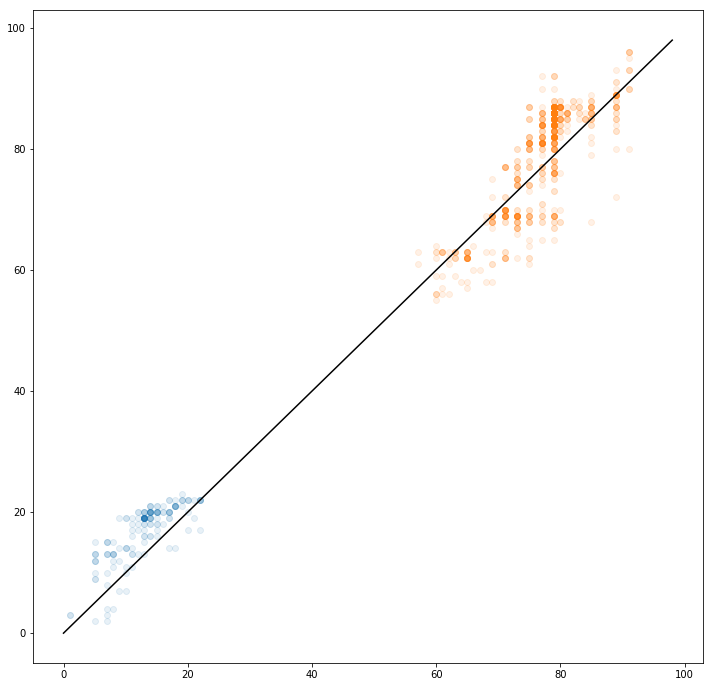

In [52]:
plt.figure(figsize=(12,12))
plt.scatter(bbch_te_0.data.cpu().numpy() * 25, ((pred_te_0) * 25).astype(int), alpha=0.1)
plt.scatter(bbch_te_1.data.cpu().numpy() * (99. - 53.) + 53, ((pred_te_1) * (99. - 53.) + 53).astype(int), alpha=0.1)
plt.plot(range(99), range(99), c='black')
# plt.xlim(0,1);
# plt.ylim(0,1);

In [53]:
prediction_b_te = np.round(ph_model_b(Variable(torch.from_numpy(temps_data_te).type(torch.FloatTensor)).to(device)).data.cpu().numpy())

In [54]:
bbch_data_te_0 = bbch_data_te[np.argwhere(prediction_b_te == 0).reshape(-1,)]
bbch_data_te_0 = bbch_data_te_0 / 25.
temps_data_te_0 = temps_data_te[np.argwhere(prediction_b_te == 0).reshape(-1,)]

bbch_data_te_1 = bbch_data_te[np.argwhere(prediction_b_te == 1).reshape(-1,)]
bbch_data_te_1 = (bbch_data_te_1 - 53) / (99 - 53)
temps_data_te_1 = temps_data_te[np.argwhere(prediction_b_te == 1).reshape(-1,)]

In [55]:
prediction_0 = ph_model_0(Variable(torch.from_numpy(temps_data_te_0.reshape(-1, 1, DAYS_IN_YEAR)).type(torch.FloatTensor)).to(device)).data.cpu().numpy()
prediction_1 = ph_model_1(Variable(torch.from_numpy(temps_data_te_1.reshape(-1, 1, DAYS_IN_YEAR)).type(torch.FloatTensor)).to(device)).data.cpu().numpy()

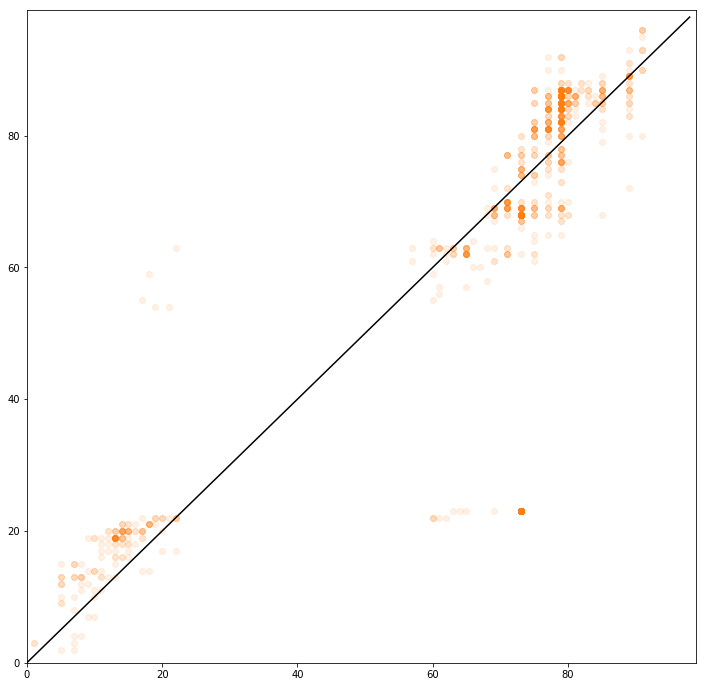

In [56]:
plt.figure(figsize=(12,12))
#plt.scatter(bbch_pred_old[:,0], bbch_pred_old[:,1], alpha=0.1, c='C0')

plt.scatter(bbch_data_te_0 * 25, ((prediction_0) * 25).astype(int), alpha=0.1, c='C1')
plt.scatter(bbch_data_te_1 * (99. - 53.) + 53, ((prediction_1) * (99. - 53.) + 53).astype(int), alpha=0.1, c='C1')

plt.plot(range(99), range(99), c='black')
plt.xlim(0,99)
plt.ylim(0,99)